In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *
import os
import pandas as pd
import numpy as np

In [3]:
path="data"

In [4]:
train_path = os.path.join(path, "train_clean")
test_path = os.path.join(path, "test.csv")

In [5]:
train_df = pd.read_pickle(train_path)
test_df = pd.read_csv(test_path)

In [6]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [7]:
n=len(train_df);n

844338

## Experimenting with Samples

What I have done in the below cell is that I have taken random rows of data in a sorted manner and picked some columns. 
We will be using these sample data to scrutunize the dataset

In [11]:
idx = np.random.permutation(range(n))[:2000]
idx.sort()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [12]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
16,17,5,"Jan,Apr,Jul,Oct",50.0,62,8430
79,80,5,NaN,7910.0,49,9810
307,309,5,"Feb,May,Aug,Nov",8740.0,61,8688
339,341,5,NaN,190.0,61,6994
575,577,5,"Mar,Jun,Sept,Dec",2270.0,61,7292


We see that promoInterval consists of some missing data, but more importatnly, it has string enteries which need to be hased to some number. Remeber the problem, Hospital-Survival-Prediction, where we had Drug column in which the string values would appear. This is the same kind of situtation. <br/>

Categorical hashing is done via Categorify in fastai. And now if we take a look at it, we see list of cats

In [13]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [14]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [16]:
small_test_df.dtypes

Store                  category
DayOfWeek              category
PromoInterval          category
CompetitionDistance     float64
Mean_Humidity             int64
Sales                     int64
dtype: object

#### Handeling Missing Data

In [18]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [19]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
130735,291,3,NaN,2520.0,89,6214,True
192043,291,2,NaN,2520.0,91,9649,True


## Preparing Full Dataset

In [22]:
train_df = pd.read_pickle(os.path.join(path, 'train_clean'))
test_df = pd.read_pickle(os.path.join(path, 'test_clean'))

In [23]:
len(train_df),len(test_df)

(844338, 41088)

So you don't have to code the preprocessors youself. In the below cell, I have created a list called procs, where I have added the list of preprocessor functions that need to take place based on the experimenting above. This list is passed to our databunch function as procs parameter which handles everything since the cardinality is not high
<br/>


In [25]:
procs=[FillMissing, Categorify, Normalize]

Specifying categorical and contineous variables for our tabular data. We have to think carefully in doing that. In the example below we have put day, year, month in categorical.

In [30]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [31]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [32]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [36]:

cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [37]:
valid_idx = range(cut)

In [38]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

Notice how in the below cell we have passed label_cls parameter. So the thing is by default it is Int. Now if the label class is Int, fastai assumes that you have categorical i;e classification problem and if we pass it as List of ints then it knows it is a regression problem


In [39]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

## Model

In [40]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

Dropout is another method of regularization. It is used for handling overfitting. ps=[] is a parameter which takes a list of dropouts i;e the amount of dropout to be implemented at those index layers in the model. The amount of dropout is given in probability

In [41]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [42]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [43]:
len(data.train_ds.cont_names)

16

In [44]:
learn.lr_find()

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


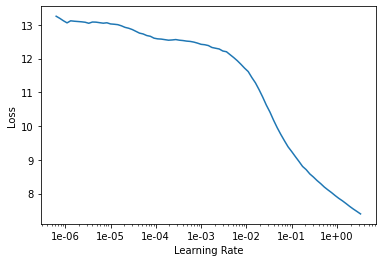

In [45]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.042145,0.027291,0.173637,13:02
1,0.040023,0.045442,0.246868,15:48
2,0.034090,0.027112,0.162768,14:50
